In [26]:
import scanpy as sc
import numpy as np
import pandas as pd
import leidenalg
import anndata as ad
import scrublet as scr
from matplotlib.pyplot import rc_context
import milopy
import milopy.core as milo
import scvelo as scv



ImportError: cannot import name 'Doc' from 'typing_extensions' (/Users/tomwolstenholme-hogg/anaconda3/lib/python3.10/site-packages/typing_extensions.py)

In [2]:
in_dat = sc.read_csv('/Users/tomwolstenholme-hogg/Documents/Research_project/GSE138852_counts.csv').transpose()
adata = sc.AnnData(in_dat)
adata.var_names_make_unique()
adata.obs_names_make_unique()

In [3]:
labels = pd.read_csv('scRNA_metadata.tsv', sep='\t')
selected_column = 'cellType'
adata.obs['cell_type'] = labels[selected_column].values

/Users/tomwolstenholme-hogg/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tomwolstenholme-hogg/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tomwolstenholme-hogg/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tomwolstenholme-hogg/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remov

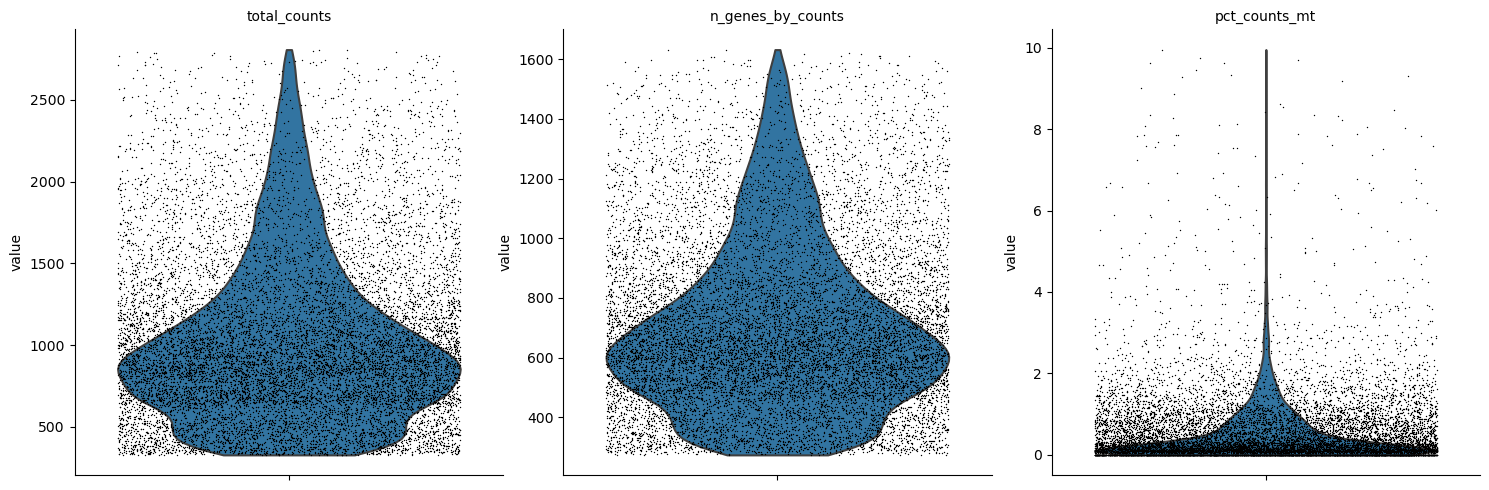

In [4]:
# Creating a column of just MT genes.
adata.var['mt'] = adata.var.index.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, keys=['total_counts', 'n_genes_by_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)





Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.54
Detected doublet rate = 1.2%
Estimated detectable doublet fraction = 33.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.7%
Elapsed time: 37.1 seconds


/Users/tomwolstenholme-hogg/anaconda3/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


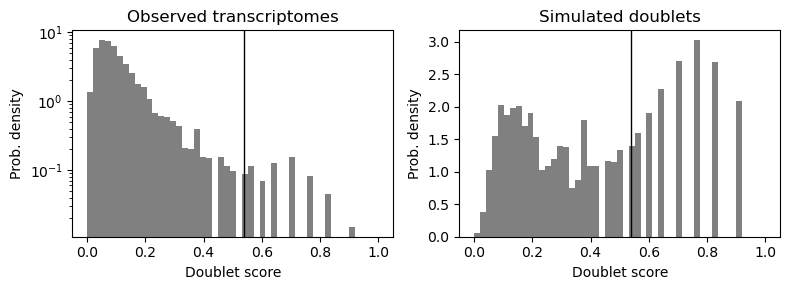

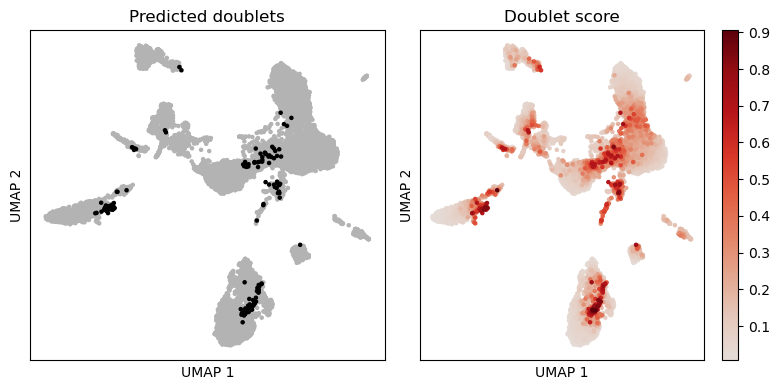

In [5]:
def scrubbing(datas):
    
    scrub = scr.Scrublet(datas.X)

    # Perform doublet detection
    scrub_results = scrub.scrub_doublets(min_counts=2, min_cells=3, n_prin_comps=30)

    datas.obs['doublet_scores'] = scrub_results[0]
    datas.obs['predicted_doublets'] = scrub_results[1]

    # Filter out predicted doublets
    datas = datas[datas.obs['predicted_doublets'] == False]

    # Ensure the AnnData object is properly updated
    datas.raw = datas.copy()
    scrub.plot_histogram()
    scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, 10, min_dist=0.3))
    scrub.plot_embedding('UMAP', order_points=True);
    datas.obs['predicted_doublets'].value_counts()
    return datas
adata = scrubbing(adata)

In [6]:
def plotting_violins(data):
    data.var['mt'] = data.var.index.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(data, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    sc.pl.violin(data, keys=['total_counts', 'n_genes_by_counts', 'total_counts_mt'], jitter=0.4, multi_panel=True)
    return data

/Users/tomwolstenholme-hogg/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tomwolstenholme-hogg/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tomwolstenholme-hogg/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tomwolstenholme-hogg/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remov

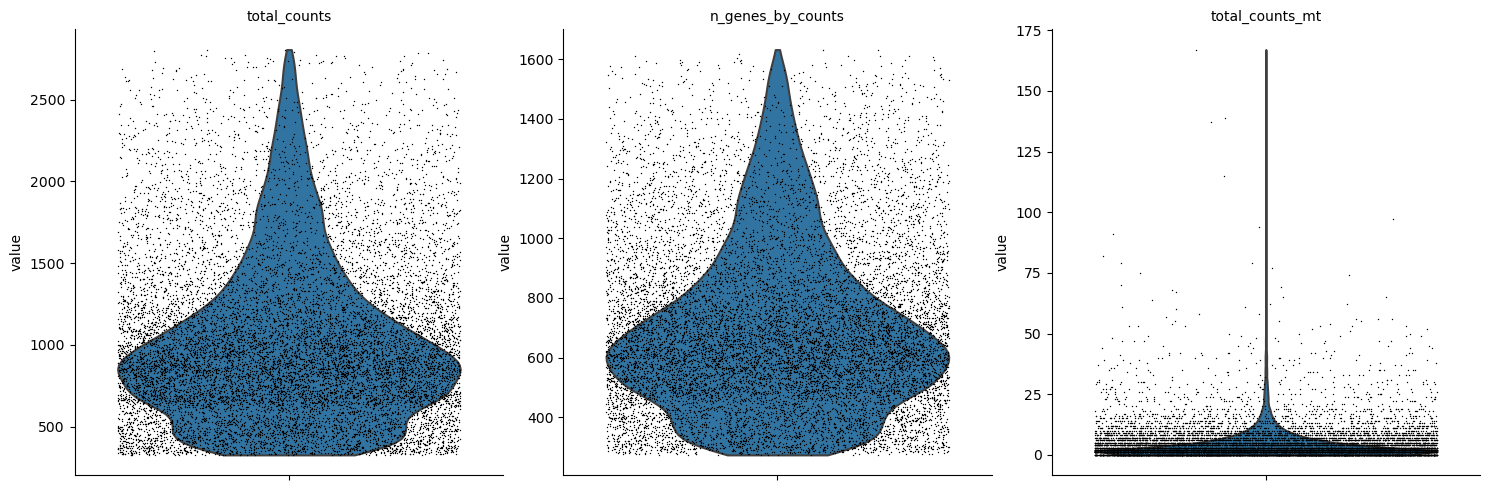

AnnData object with n_obs × n_vars = 13050 × 10850
    obs: 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_scores', 'predicted_doublets'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [7]:
plotting_violins(adata)

In [8]:
def normalisation(data):
    sc.pp.normalize_total(data, target_sum=1e4) # Normalises every cell to 10,000 UMI (10,000 unique molecular identifiers)
    data.X.sum(axis=1)
    sc.pp.log1p(data)
    sc.pp.highly_variable_genes(data, n_top_genes= 2000)
    data.raw = data
    return data

# Makes the numbers more comparable
adata = normalisation(adata)

/Users/tomwolstenholme-hogg/anaconda3/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


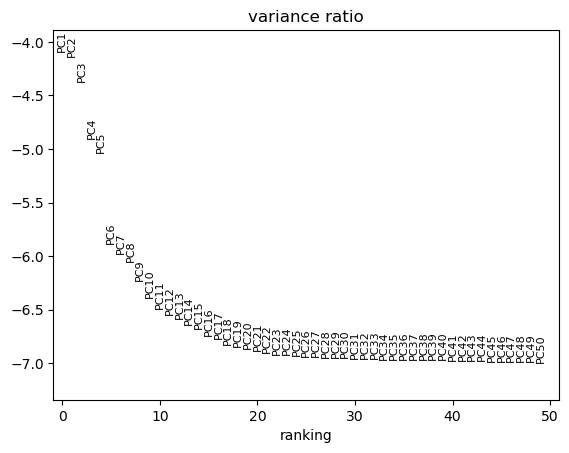

In [9]:
# PCA function
def PCA(data, pcs):
    data = data[:, data.var.highly_variable]
    sc.pp.regress_out(data, ['total_counts', 'pct_counts_mt', 'n_genes_by_counts'])
    sc.pp.scale(data, max_value=10) 
    sc.tl.pca(data, svd_solver='arpack')
    sc.pl.pca_variance_ratio(data, log=True, n_pcs= pcs)
    data.raw = data
    return data

adata = PCA(adata, 50)

In [10]:
# Able to see eigen value for each PC, allows us to workout the the percentage
# variance that each PC shows.
d = adata.uns['pca']['variance'] 

def percentage_variance_calc(data):
    count = 0
    n = 0
    for i in data:
        n = n + (100*i/sum(data))
        print(n)
        count += 1
        print(count)
# for loop to workout the percentage variance so I know where to chop it off
percentage_variance_calc(d)

14.954257318526883
1
29.312297608518737
2
40.65482762081953
3
47.32698853933102
4
53.16729891316624
5
55.66165393376836
6
57.935769642195794
7
60.0357875410661
8
61.79653520148992
9
63.30254675124493
10
64.66377696486555
11
65.95323037199579
12
67.18643228188014
13
68.35944064768682
14
69.4840389451428
15
70.53562504662918
16
71.55832287786333
17
72.53301795595776
18
73.48792280345242
19
74.42371850115562
20
75.34561137298199
21
76.25060083021218
22
77.13914101930685
23
78.02548297287258
24
78.90172737570077
25
79.77350081078559
26
80.64131614419738
27
81.50326723852218
28
82.36380800670665
29
83.22151517874188
30
84.07576828223408
31
84.92904520693642
32
85.77902411170832
33
86.62607586893775
34
87.47215105850573
35
88.31785037590821
36
89.16100919523198
37
90.00262758309297
38
90.84400237068117
39
91.68472407621533
40
92.52333298686355
41
93.35966938750967
42
94.19433247371637
43
95.02807676746886
44
95.860324627801
45
96.69068262777279
46
97.52079719413103
47
98.34930972065648
48
99

In [11]:
sc.pp.neighbors(adata, n_pcs= 30) # Forms neighbourhood matrices.
sc.tl.leiden(adata) # Needed to add this in for some reason when i re ran it, but now it works, looks different to before.
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False) # Can remove plot=False if we want to remove the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

In [12]:
adata.obs.keys
adata.obs['sample_ID'] = list(map(lambda x: "_".join(x.split("_")[1:]), adata.obs.index))
adata.obs['sequence'] = list(map(lambda x: "_".join(x.split("_")[0:1]), adata.obs.index))
adata.obs

,cell_type,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,doublet_scores,predicted_doublets,leiden,sample_ID,sequence
AAACCTGGTAGAAAGG_AD5_AD6,oligo,564,760.0,3.0,0.394737,0.337662,False,6,AD5_AD6,AAACCTGGTAGAAAGG
AAACCTGGTAGCGATG_AD5_AD6,oligo,527,720.0,21.0,2.916667,0.104000,False,6,AD5_AD6,AAACCTGGTAGCGATG
AAACCTGTCAGTCAGT_AD5_AD6,oligo,773,1209.0,14.0,1.157982,0.126390,False,6,AD5_AD6,AAACCTGTCAGTCAGT
AAACCTGTCCAAACAC_AD5_AD6,oligo,615,925.0,1.0,0.108108,0.190736,False,6,AD5_AD6,AAACCTGTCCAAACAC
AAACCTGTCCAGTATG_AD5_AD6,oligo,434,562.0,3.0,0.533808,0.111732,False,6,AD5_AD6,AAACCTGTCCAGTATG
...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCCGTACAA_AD1_AD2,oligo,339,442.0,2.0,0.452489,0.247492,False,2,AD1_AD2,TTTGGTTTCCGTACAA
TTTGTCACAAGCCATT_AD1_AD2,doublet,459,532.0,13.0,2.443609,0.067680,False,2,AD1_AD2,TTTGTCACAAGCCATT
TTTGTCAGTATAGGTA_AD1_AD2,doublet,330,383.0,4.0,1.044386,0.450000,False,8,AD1_AD2,TTTGTCAGTATAGGTA
TTTGTCATCCACTGGG_AD1_AD2,oligo,603,868.0,6.0,0.691244,0.111732,False,2,AD1_AD2,TTTGTCATCCACTGGG


In [13]:
adata.obs['Disease_status'] = list(map(lambda x: x[0:2], adata.obs['sample_ID']))
pd.DataFrame(adata.obs['Disease_status']).value_counts()

Disease_status
AD                6616
Ct                6434
Name: count, dtype: int64

/Users/tomwolstenholme-hogg/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/tomwolstenholme-hogg/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/tomwolstenholme-hogg/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categoric

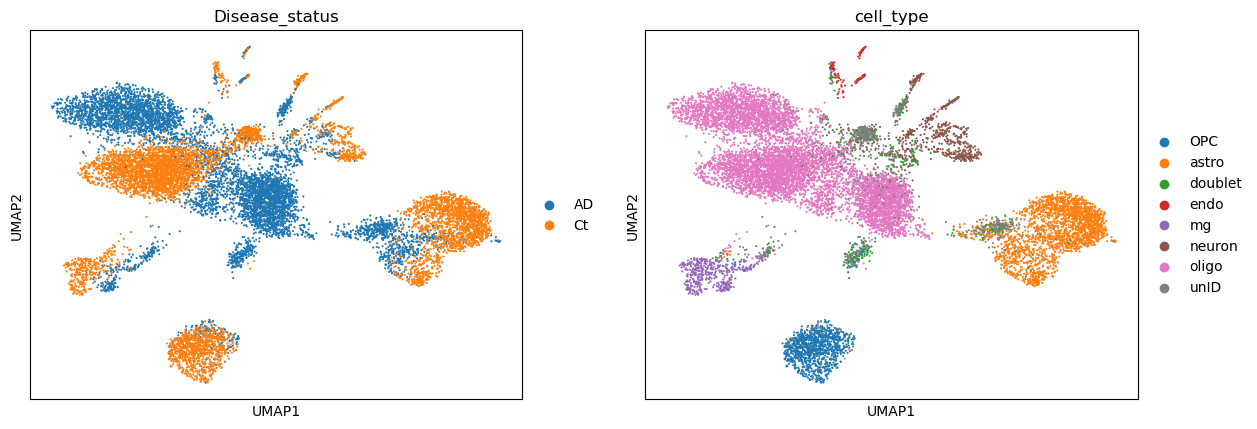

In [14]:
sc.pl.umap(adata, color=['Disease_status', 'cell_type'])


In [22]:
sc.pp.neighbors(adata, n_neighbors= 10)
milo.make_nhoods(adata)

# Counting the number of each cell type
milo.count_nhoods(adata, sample_col='sample_ID')

# Comparing between the case and control,
# tried using the sequence so that it would be unique but it still doesn't work
milo.DA_nhoods(adata, design= "~ Disease_status")

# Checking the results
milo_results = adata.uns['nhood_adata'].obs
print(milo_results)




/Users/tomwolstenholme-hogg/anaconda3/lib/python3.10/site-packages/milopy/core.py:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[14.80498505  7.35529041  7.38868093  8.11577225  5.85227728  7.64516973
  7.80885029  7.37474537  8.60909843  8.02159214  6.14738226  8.66862202
  7.30666304 15.55515194 10.32846832  6.68977737  6.4713397   9.25359726
  7.1941371  10.29939651  7.49439669  9.02973557  8.53719711 10.35672092
  7.29941416  7.00349855  6.66385221  9.07768631  6.95851135  7.91810656
  6.59790707  6.99809408  7.75233316 12.98841667 10.96312714  7.69175911
  5.97993135  7.93775129  9.24996758  7.19475365 16.39673615 14.95039463
  7.37844801  6.84810543 15.0777092   6.58176088  7.30147743  5.58893776
  5.31076431  5.95174122  5.69782162  5.91334915  7.34471464  6.09061718
  6.81726837  6.07337856  6.36204386  8.33390713  5.80394363  6.44228935
  9.20541763 10.31164074  6.07802916  5.86393785  6.19393349  6.3

AnnData object with n_obs × n_vars = 13050 × 2000
    obs: 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_scores', 'predicted_doublets', 'leiden', 'sample_ID', 'sequence', 'Disease_status', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'paga', 'leiden_sizes', 'umap', 'Disease_status_colors', 'cell_type_colors', 'nhood_neighbors_key', 'nhood_adata'
    obsm: 'X_pca', 'X_umap', 'nhoods'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
                   index_cell  kth_distance     logFC     logCPM         F  \
0    AACTTTCGTCTAAAGA_AD5_AD6     14.804985 -0.482367   9.718585  0.070804   
1    AAGACCTAGATCCTGT_AD5_AD6      7.355290 -2.776831  10.575094  1.914828   
2    AGCGTCGCACATCTTT_AD5_AD6     

/Users/tomwolstenholme-hogg/anaconda3/lib/python3.10/site-packages/milopy/core.py:239: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if design_df.dtypes[i].name == 'category':
/Users/tomwolstenholme-hogg/anaconda3/lib/python3.10/site-packages/milopy/core.py:311: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvalues = pvalues[keep_nhoods][o]
/Users/tomwolstenholme-hogg/anaconda3/lib/python3.10/site-packages/milopy/core.py:312: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

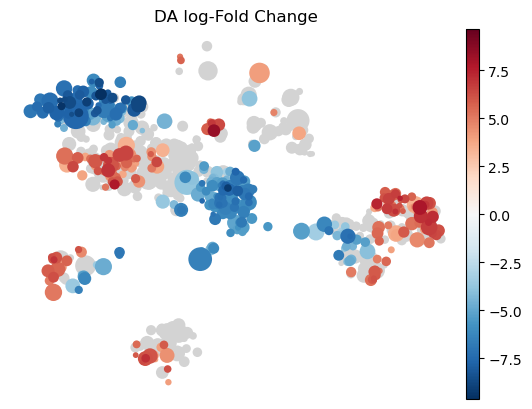

/Users/tomwolstenholme-hogg/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/tomwolstenholme-hogg/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/tomwolstenholme-hogg/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categoric

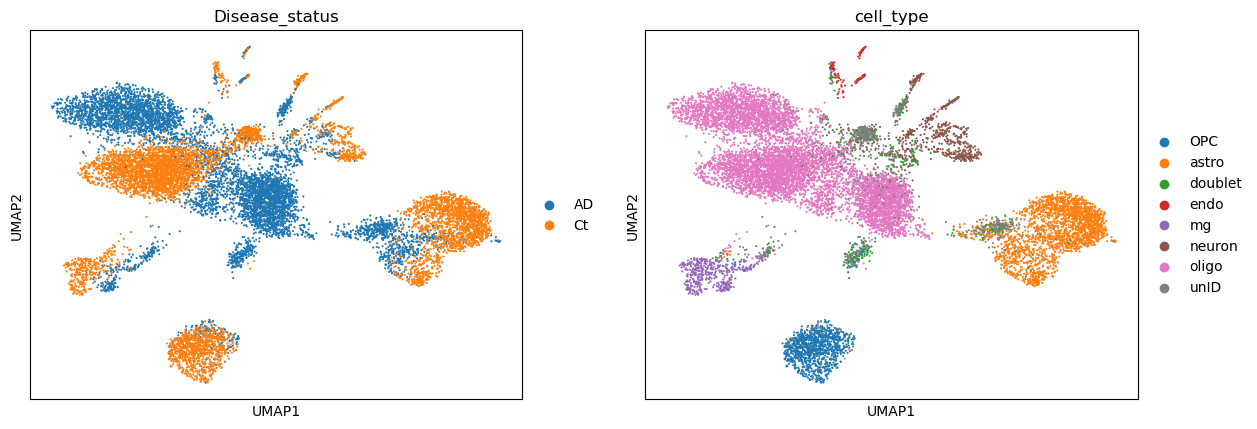

In [25]:
milopy.utils.build_nhood_graph(adata)
milopy.plot.plot_nhood_graph(adata, alpha=0.2, min_size=5)
sc.pl.umap(adata, color=['Disease_status', 'cell_type'])

In [ ]:
scv.tl.velocity(adata, mode='stochastic')
scv.tl.velocity_graph(adata)
# Meant to add parameters to both of these

In [ ]:
# Visualising the data, add same params to these
scv.pl.velocity_embedding(adata, basis='umap')
scv.pl.velocity_embedding_grid(adata, basis='umap')
scv.pl.velocity_embedding_stream(adata, basis= 'umap')

In [ ]:
scv.pl.velocity_embedding(adata, arrow_length=3, arrow_size=2, dpi= 120)

In [ ]:
# Doing the plotting counterpart, allows us to examine our results in detail
scv.pl.velocity(adata, var_names='cell_type')
scv.pl.velocity_graph(adata)

In [ ]:
scv.pl.proportions(adata)

In [ ]:
# Just another way to visualise the data, plot all of them to see which George prefers

scv.pl.scatter(adata, 'Cpe', color=['leiden', 'velocity'],
               add_outline='cell_type')

In [ ]:
# Identifying the important genes

scv.tl.rank_velocity_genes(adata, groupby='leiden', min_corr= .3)
df = scv.DataFrame(adata.uns['rank_velocity_genes']['cell_types'])
df.head()

In [ ]:
scv.tl.score_genes_cell_cycle(adata)
scv.pl.scatter(adata, color_gradients=['S_score', 'G2M_score'], smooth=True, perc=[5, 95])


In [ ]:
# Doing the speed and coherence
# Tells us where cells differentiate at a slower/faster pace, and where direction is un-/determined

scv.tl.velocity_confidence(adata)
keys = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(adata, c=keys, cmap='coolwarm', perc=[5, 95])

In [ ]:
# Able to draw the descendents coming from a specified cell, so we can track an early cell
# To its potential fate

x, y = scv.utils.get_cell_transitions(adata, basis='umap', starting_cell=70)
ax = scv.pl.velocity_graph(adata, c='lightgrey', edge_width=.05, show= False)
ax = scv.pl.scatter(adata, x=x, y=y, s=120, c='ascending', cmap='gnuplot', ax=ax)

In [ ]:
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(adata, color='velocity_pseudotime', cmap='gnuplot')